In [20]:
"""
Boulder County historical ignitions
"""

import os
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready !")

Ready !


In [4]:
# Load the FPA-FOD for the western U.S.
fp = os.path.join(projdir, 'data/spatial/raw/USFS/FPA_FOD/fpa-fod_west.gpkg')
fpa_fod = gpd.read_file(fp)
fpa_fod.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID',
       'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE',
       'NWCG_CAUSE_AGE_CATEGORY', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
       'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR',
       'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'geometry'],
      dtype='object')

In [9]:
# get the first and last year for BOCO

In [15]:
fpa_fod_co = fpa_fod[fpa_fod['STATE'] == 'CO']
print(f"There are {len(fpa_fod_co)} ignitions in Colorado.")
print(f"Starting in {fpa_fod_co['FIRE_YEAR'].min()} up to {fpa_fod_co['FIRE_YEAR'].max()}")

There are 68629 ignitions in Colorado.
Starting in 1992 up to 2020


In [16]:
# load boulder county boundary
fp = os.path.join(maindir, 'data/boundaries/political/TIGER/tl19_us_counties_conus.gpkg')
counties = gpd.read_file(fp)
boco = counties[counties['NAME'] == 'Boulder']
boco.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
593,08,013,00198122,08013,Boulder,Boulder County,06,H1,G4020,216,14500,NaN,A,1881309466,36493405,+40.0949699,-105.3976911,"MULTIPOLYGON (((-105.64858 40.06198, -105.6480..."


In [86]:
# ensure the same projection
fpa_fod_co = fpa_fod_co.to_crs('EPSG:32613')
boco = boco.to_crs('EPSG:32613')

# do a spatial overlay
boco_ig = gpd.overlay(fpa_fod_co, boco, how='intersection')
print(f"There are {len(boco_ig)} ignitions in Boulder County, CO.")
print(f"Starting in {boco_ig['FIRE_YEAR'].min()} up to {boco_ig['FIRE_YEAR'].max()}")

There are 2474 ignitions in Boulder County, CO.
Starting in 1992 up to 2020


In [87]:
boco_ig['FIRE_SIZE_CLASS'].unique()

array(['A', 'B', 'E', 'C', 'F', 'G', 'D'], dtype=object)

In [88]:
# load the road data
roads = os.path.join(maindir, 'data/boundaries/political/TIGER/roads/tl_2019_08_prisecroads.shp')
roads = gpd.read_file(roads)
# overlay w/ Boulder County
roads_boco = roads.to_crs('EPSG:32613')
roads_boco = gpd.overlay(roads_boco, boco, how='intersection')

/opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/lm/1zg27k9x385csjv9gkj8jqm80000gp/T/ipykernel_6844/1373339282.py:6: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  roads_boco = gpd.overlay(roads_boco, boco, how='intersection')


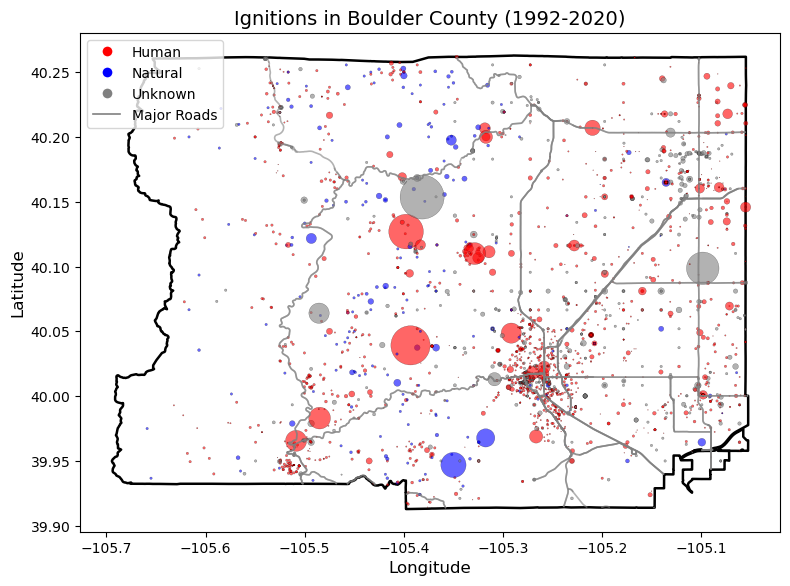

In [113]:
# Make a spatial map of the ignitions
boco_ig['NWCG_CAUSE_CLASSIFICATION'] = boco_ig['NWCG_CAUSE_CLASSIFICATION'].replace(
    'Missing data/not specified/undetermined', 'Unknown'
)

color_mapping = {
    'Human': 'red',
    'Natural': 'blue',
    'Unknown': 'gray'
}

boco_ig['color'] = boco_ig['NWCG_CAUSE_CLASSIFICATION'].map(color_mapping)

boco_ig = boco_ig.to_crs('EPSG:4326')
boco = boco.to_crs('EPSG:4326')
roads_boco = roads_boco.to_crs('EPSG:4326')

# create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the county boundary
boco.plot(ax=ax, edgecolor='black', linewidth=1.8, color='none')

# Plot ignitions with size based on FIRE_SIZE and color by cause
scatter = ax.scatter(
    boco_ig.geometry.x, 
    boco_ig.geometry.y, 
    c=boco_ig['color'], 
    s=np.sqrt(boco_ig['FIRE_SIZE']) * 10,  # Scale for better visibility
    alpha=0.6, 
    edgecolor='k', 
    linewidth=0.2
)

# add roads
roads_boco.plot(ax=ax, color='gray', linewidth=1.2, alpha=0.6, label='Major Roads')

# Create a legend for ignition cause
legend_elements = []
# Add ignition causes first
for cause, color in color_mapping.items():
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=cause)
    )
# Add roads last
legend_elements.append(Line2D([0], [0], color='gray', linewidth=1.2, label='Major Roads'))

# Add the combined legend
ax.legend(handles=legend_elements, loc='upper left', frameon=True, fontsize=10)

ax.set_title('Ignitions in Boulder County (1992-2020)', fontsize=14)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.tight_layout()

# Save the map as a PNG
plt.savefig(os.path.join(projdir, 'figures/BoulderCounty_Ignitions_FPA-FOD.png'), dpi=300, bbox_inches='tight')

plt.show()

NWCG_CAUSE_CLASSIFICATION  Human  Natural  Unknown
FIRE_YEAR                                         
1992                        39.0     12.0     64.0
1993                        46.0     14.0     45.0
1994                        22.0     25.0     45.0
Human
Natural
Unknown


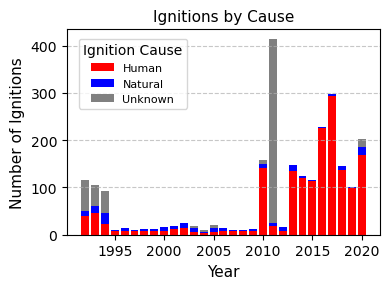

In [111]:
# tidy the dataframe for plotting
ignition_counts = boco_ig.groupby(['FIRE_YEAR', 'NWCG_CAUSE_CLASSIFICATION']).size().reset_index(name='count')
ignition_counts = ignition_counts.pivot(index='FIRE_YEAR', columns='NWCG_CAUSE_CLASSIFICATION', values='count').fillna(0)
print(ignition_counts.head(3))

# Plot the time-series
# Initialize the plot
fig, ax = plt.subplots(figsize=(4, 3))

# Initialize bottom for stacking
bottom = np.zeros(len(ignition_counts))

# Iterate through each cause and plot its bar
for cause in ignition_counts.columns:
    print(cause)
    ax.bar(
        ignition_counts.index, 
        ignition_counts[cause], 
        bottom=bottom, 
        label=cause, 
        color=color_mapping.get(cause, 'blue')  # Default to blue if cause not in mapping
    )
    bottom += ignition_counts[cause].values  # Update the bottom for stacking

# Add labels and legend
ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('Number of Ignitions', fontsize=11)
ax.legend(
    title='Ignition Cause', 
    loc='upper left', 
    bbox_to_anchor=(0.02, 0.98),  # Offset for positioning inside the plot
    frameon=True,  # Add a background box for better readability
    fontsize=8
)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_title('Ignitions by Cause', fontsize=11)

plt.tight_layout()

# Save the map as a PNG
plt.savefig(os.path.join(projdir, 'figures/BoulderCounty_Ignitions_FPA-FOD_TimeSeries.png'), dpi=300, bbox_inches='tight')

plt.show()

Human
Natural
Unknown


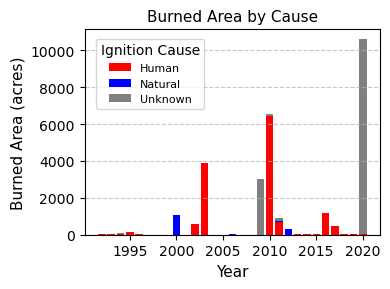

In [112]:
# Aggregate burned area by FIRE_YEAR and NWCG_CAUSE_CLASSIFICATION
burned_area = boco_ig.groupby(['FIRE_YEAR', 'NWCG_CAUSE_CLASSIFICATION'])['FIRE_SIZE'].sum().reset_index()
burned_area = burned_area.pivot(index='FIRE_YEAR', columns='NWCG_CAUSE_CLASSIFICATION', values='FIRE_SIZE').fillna(0)

# Plot the time-series for burned area
fig, ax = plt.subplots(figsize=(4, 3))

# Initialize bottom for stacking
bottom = np.zeros(len(burned_area))

# Iterate through each cause and plot its bar
for cause in burned_area.columns:
    print(cause)
    ax.bar(
        burned_area.index, 
        burned_area[cause], 
        bottom=bottom, 
        label=cause, 
        color=color_mapping.get(cause, 'blue')  # Default to blue if cause not in mapping
    )
    bottom += burned_area[cause].values  # Update the bottom for stacking

# Add labels and legend
ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('Burned Area (acres)', fontsize=11)
ax.legend(
    title='Ignition Cause', 
    loc='upper left', 
    bbox_to_anchor=(0.02, 0.98),  # Offset for positioning inside the plot
    frameon=True,  # Add a background box for better readability
    fontsize=8
)
ax.set_title('Burned Area by Cause', fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Save the map as a PNG
plt.savefig(os.path.join(projdir, 'figures/BoulderCounty_BurnedArea_FPA-FOD-TimeSeries.png'), dpi=300, bbox_inches='tight')

plt.show()